In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap
import os
import sys

if not os.path.join(os.path.abspath(''), '../') in sys.path:
    sys.path.append(os.path.join(os.path.abspath(''), '../'))
    
from utils.classification import load_model, load_features, load_data, weighted_smoothing, load_behaviors
from utils.meta import *
from utils.feature_utils import get_avg_kinematics
from tqdm import notebook
import pickle
import os
import pandas as pd
import umap
from sklearn.preprocessing import LabelEncoder
import warnings

### load model, preprocessed pose (filter out low likelihood), and binned features (smoothed distances, speed, angle etc)

In [2]:
data_path = '../processed_dataset/raw_data_groups_sni_combined.pkl'
poses = load_data(data_path)

behavior_data_path = '../processed_dataset/behaviors_sni_combined.pkl'
behaviors = load_behaviors(behavior_data_path)

In [5]:
print(keypoints)

['nose', 'mouth', 'l_forepaw', 'l_forepaw_digit', 'r_forepaw', 'r_forepaw_digit', 'l_hindpaw', 'l_hindpaw_digit1', 'l_hindpaw_digit2', 'l_hindpaw_digit3', 'l_hindpaw_digit4', 'l_hindpaw_digit5', 'r_hindpaw', 'r_hindpaw_digit1', 'r_hindpaw_digit2', 'r_hindpaw_digit3', 'r_hindpaw_digit4', 'r_hindpaw_digit5', 'genitalia', 'tail_base']


## MAIN CODE - Single Body Part, Single Condition

In [5]:
bp_selects = "genitalia"

# Define specific groups and conditions
selected_group = ['C_3WSNI_DCZ']
# 'A_Baseline_NoSNI', 'B_Baseline_SNI', 'C_3WSNI_DCZ', 'D_4WSNI_DCZ'
selected_condition = ['control_mMORP-eYFP']
#selected_conditions = ['exp_mMORP-hm4di']

bout_disp_bps = []
# bout_duration_bps = []
# bout_avg_speed_bps = []
# behavior_all_bps = []
for bp_select in [bp_selects]:
    bodypart = keypoints.index(bp_select)
    bout_disp_all = []
    # behavior_all = []
    for i in range(len(behaviors[selected_group][selected_condition])):
        behavior, behavioral_start_time, behavior_duration, bout_disp, bout_duration, bout_avg_speed = \
            get_avg_kinematics(behaviors[selected_group][selected_condition][f'file{i}'],
                               poses[selected_group][selected_condition][f'file{i}'], 
                               bodypart, framerate=60)
        bout_disp_all.append(bout_disp)
    # per bout, average total bodypart movement in pixel displacement,
    # then look at distribution across bouts, across files (as some files don't have bouts)
    bout_disp_bps.append(bout_disp_all)

TypeError: unhashable type: 'list'

In [14]:
behavioral_sums = {key: [] for key in behavior_names}

# look at speed for each behavior
for b, behav in enumerate(behavior_names):
    behavioral_sums[behav] = np.hstack([np.hstack(
        [bout_disp_bps[bp][f][behav]
         for f in range(len(bout_disp_bps[bp]))])
        for bp in range(len(bout_disp_bps))])
max_perb = []
for beh in list(behavioral_sums.keys()):
    if len(behavioral_sums[beh]) > 10:
        max_perb.append(np.percentile(behavioral_sums[beh], 95))
max_all = np.max(max_perb)
# movement_n_bins = st.slider('number of movement bins',
#                             min_value=5,
#                             max_value=30,
#                             value=10, key=f'move_bin_slider_{condition}')
movement_n_bins = 10
pre_alloc_movement = np.zeros((len(list(behavioral_sums.keys())), movement_n_bins))
label_encoder = LabelEncoder()
for b, behav in enumerate(list(behavioral_sums.keys())):
    df = pd.DataFrame(data=behavioral_sums[behav],
                      columns=['bp_movement'])
    n_bins = np.linspace(0, max_all, movement_n_bins)
    y = label_encoder.fit_transform(pd.cut(df['bp_movement'], n_bins, retbins=True)[0])
    pre_alloc_movement[b, :] = np.histogram(y, bins=np.arange(0, movement_n_bins+1))[0]
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    row_sums = pre_alloc_movement.sum(axis=1)
    movement_by_behav = pre_alloc_movement / row_sums[:, np.newaxis]

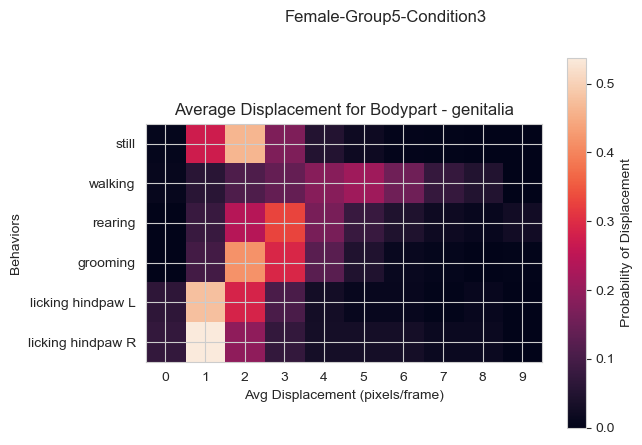

In [16]:
import matplotlib.pyplot as plt
import numpy as np

heatmap = plt.imshow(movement_by_behav)  # Assuming 'viridis' colormap, change as needed

plt.title(f'Average Displacement for Bodypart - {bp_selects}')
plt.suptitle(f'{selected_sex}-{selected_group}-{selected_condition}')

plt.xlabel('Avg Displacement (pixels/frame)')
plt.ylabel('Behaviors')

plt.xticks(range(len(movement_by_behav[0])))
plt.yticks(range(len(behavior_names)), behavior_names)

# For annotating each cell w/ probability value
#for i in range(len(behavior_names)):
    #for j in range(len(movement_by_behav[0])):
        #text = plt.text(j, i, f'{movement_by_behav[i, j]:.2f}',
                        #ha='center', va='center', color='white')

plt.colorbar(heatmap, label='Probability of Displacement')

plt.imshow(movement_by_behav)

## MAIN CODE - Male vs Female Comparison - Single Body Part, Single Condition

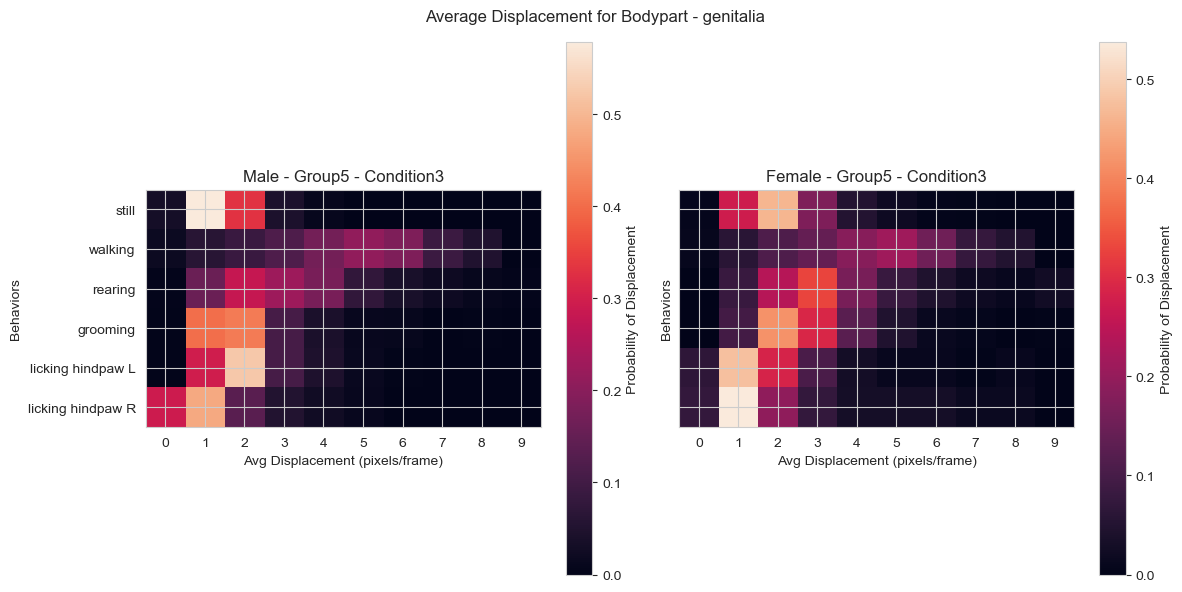

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from sklearn.preprocessing import LabelEncoder

bp_selects = "genitalia"
selected_group = 'A_Baseline_NoSNI'
selected_condition = 'control_mMORP-eYFP'

# Initialize an empty dictionary to hold the results for each sex
movement_by_sex = {}

for selected_sex in selected_sexes:
    bout_disp_bps = []

    for bp_select in [bp_selects]:
        bodypart = keypoints.index(bp_select)
        bout_disp_all = []

        # Iterate over behaviors for the selected sex, group, and condition
        for i in range(len(behaviors[selected_sex][selected_group][selected_condition])):
            behavior, behavioral_start_time, behavior_duration, bout_disp, bout_duration, bout_avg_speed = \
                get_avg_kinematics(behaviors[selected_sex][selected_group][selected_condition][f'file{i}'],
                                   poses[selected_sex][selected_group][selected_condition][f'file{i}'], 
                                   bodypart, framerate=60)
            bout_disp_all.append(bout_disp)

        bout_disp_bps.append(bout_disp_all)

    behavioral_sums = {key: [] for key in behavior_names}
    for b, behav in enumerate(behavior_names):
        behavioral_sums[behav] = np.hstack([np.hstack(
            [bout_disp_bps[bp][f][behav]
             for f in range(len(bout_disp_bps[bp]))])
            for bp in range(len(bout_disp_bps))])

    # Find the maximum displacement among all behaviors
    max_perb = []
    for beh in list(behavioral_sums.keys()):
        if len(behavioral_sums[beh]) > 10:
            max_perb.append(np.percentile(behavioral_sums[beh], 95))
    max_all = np.max(max_perb)

    # Define the number of movement bins
    movement_n_bins = 10

    pre_alloc_movement = np.zeros((len(list(behavioral_sums.keys())), movement_n_bins))
    label_encoder = LabelEncoder()

    # Create histogram of displacements for each behavior
    for b, behav in enumerate(list(behavioral_sums.keys())):
        df = pd.DataFrame(data=behavioral_sums[behav],
                          columns=['bp_movement'])
        n_bins = np.linspace(0, max_all, movement_n_bins)
        y = label_encoder.fit_transform(pd.cut(df['bp_movement'], n_bins, retbins=True)[0])
        pre_alloc_movement[b, :] = np.histogram(y, bins=np.arange(0, movement_n_bins+1))[0]

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        row_sums = pre_alloc_movement.sum(axis=1)
        movement_by_behav = pre_alloc_movement / row_sums[:, np.newaxis]

    movement_by_sex[selected_sex] = movement_by_behav

# Plotting
fig, axes = plt.subplots(1, len(selected_sexes), figsize=(12, 6), sharey=True)

for i, selected_sex in enumerate(selected_sexes):
    ax = axes[i]
    heatmap = ax.imshow(movement_by_sex[selected_sex])

    ax.set_title(f'{selected_sex} - {selected_group} - {selected_condition}')
    ax.set_xlabel('Avg Displacement (pixels/frame)')
    ax.set_ylabel('Behaviors')

    ax.set_xticks(np.arange(len(movement_by_sex[selected_sex][0])))
    ax.set_yticks(np.arange(len(behavior_names)))
    ax.set_yticklabels(behavior_names)

    fig.colorbar(heatmap, ax=ax, label='Probability of Displacement')

plt.suptitle(f'Average Displacement for Bodypart - {bp_selects}')
plt.tight_layout()

plt.savefig(f'../figures/behavior_kinematx/avg_displacement_sexes_{selected_group}-{selected_condition}_{bp_selects}.svg', format='svg')


plt.show()

## MAIN CODE - FIG - COMBINED Male Female - Single Body Part, Single Condition

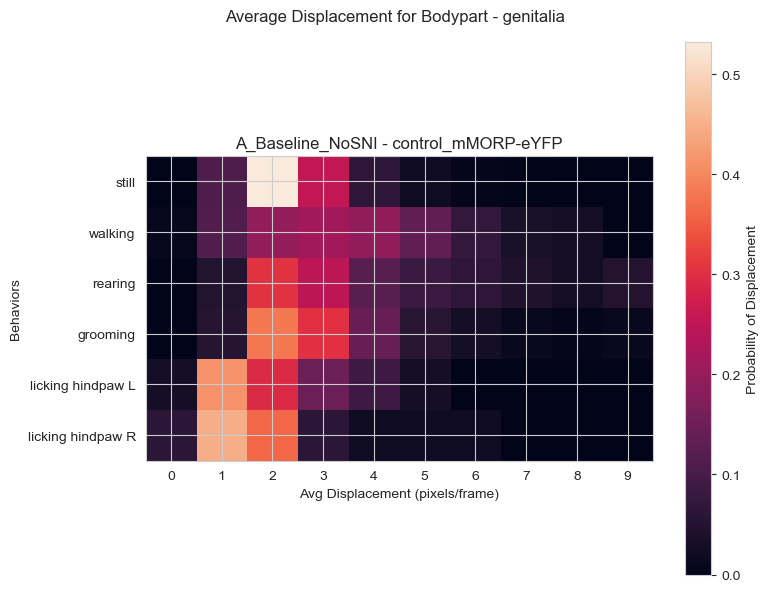

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from sklearn.preprocessing import LabelEncoder

bp_selects = "genitalia"
selected_group = ['A_Baseline_NoSNI']
# 'A_Baseline_NoSNI', 'B_Baseline_SNI', 'C_3WSNI_DCZ', 'D_4WSNI_DCZ'
selected_condition = ['control_mMORP-eYFP']
#selected_conditions = ['exp_mMORP-hm4di']

# Initialize an empty dictionary to hold the results
movement_by_group_condition = {}

bout_disp_bps = []

for bp_select in [bp_selects]:
    bodypart = keypoints.index(bp_select)
    bout_disp_all = []

    # Iterate over behaviors for the selected group and condition
    for i in range(len(behaviors[selected_group][selected_condition])):
        behavior, behavioral_start_time, behavior_duration, bout_disp, bout_duration, bout_avg_speed = \
            get_avg_kinematics(behaviors[selected_group][selected_condition][f'file{i}'],
                               poses[selected_group][selected_condition][f'file{i}'], 
                               bodypart, framerate=60)
        bout_disp_all.append(bout_disp)

    bout_disp_bps.append(bout_disp_all)

behavioral_sums = {key: [] for key in behavior_names}
for b, behav in enumerate(behavior_names):
    behavioral_sums[behav] = np.hstack([np.hstack(
        [bout_disp_bps[bp][f][behav]
         for f in range(len(bout_disp_bps[bp]))])
        for bp in range(len(bout_disp_bps))])

# Find the maximum displacement among all behaviors
max_perb = []
for beh in list(behavioral_sums.keys()):
    if len(behavioral_sums[beh]) > 10:
        max_perb.append(np.percentile(behavioral_sums[beh], 95))
max_all = np.max(max_perb)

# Define the number of movement bins
movement_n_bins = 10

pre_alloc_movement = np.zeros((len(list(behavioral_sums.keys())), movement_n_bins))
label_encoder = LabelEncoder()

# Create histogram of displacements for each behavior
for b, behav in enumerate(list(behavioral_sums.keys())):
    df = pd.DataFrame(data=behavioral_sums[behav],
                      columns=['bp_movement'])
    n_bins = np.linspace(0, max_all, movement_n_bins)
    y = label_encoder.fit_transform(pd.cut(df['bp_movement'], n_bins, retbins=True)[0])
    pre_alloc_movement[b, :] = np.histogram(y, bins=np.arange(0, movement_n_bins+1))[0]

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    row_sums = pre_alloc_movement.sum(axis=1)
    movement_by_behav = pre_alloc_movement / row_sums[:, np.newaxis]

movement_by_group_condition[(selected_group, selected_condition)] = movement_by_behav

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

heatmap = ax.imshow(movement_by_group_condition[(selected_group, selected_condition)])

ax.set_title(f'{selected_group} - {selected_condition}')
ax.set_xlabel('Avg Displacement (pixels/frame)')
ax.set_ylabel('Behaviors')

ax.set_xticks(np.arange(len(movement_by_behav[0])))
ax.set_yticks(np.arange(len(behavior_names)))
ax.set_yticklabels(behavior_names)

fig.colorbar(heatmap, ax=ax, label='Probability of Displacement')

plt.suptitle(f'Average Displacement for Bodypart - {bp_selects}')
plt.tight_layout()

plt.savefig(f'../figures/behavior_kinematx/avg_displacement_{selected_group}-{selected_condition}_{bp_selects}.svg', format='svg')

plt.show()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from sklearn.preprocessing import LabelEncoder

# List of body parts to iterate over
body_parts = ["l_hindpaw", "l_hindpaw_digit1", "l_hindpaw_digit2", "l_hindpaw_digit3", "l_hindpaw_digit4", "l_hindpaw_digit5"]
#body_parts = ["r_hindpaw", "r_hindpaw_digit1", "r_hindpaw_digit2", "r_hindpaw_digit3", "r_hindpaw_digit4", "r_hindpaw_digit5"]

selected_group = 'C_3WSNI_DCZ'  
# 'A_Baseline_NoSNI', 'B_Baseline_SNI', 'C_3WSNI_DCZ', 'D_4WSNI_DCZ'

selected_condition = 'control_mMORP-eYFP'
#selected_condition = 'exp_mMORP-hm4di'

# Initialize an empty dictionary to hold the results
movement_by_group_condition = {}

for bp_selects in body_parts:
    bout_disp_bps = []

    for bp_select in [bp_selects]:
        bodypart = keypoints.index(bp_select)
        bout_disp_all = []

        for i in range(len(behaviors[selected_group][selected_condition])):
            behavior, behavioral_start_time, behavior_duration, bout_disp, bout_duration, bout_avg_speed = \
                get_avg_kinematics(behaviors[selected_group][selected_condition][f'file{i}'],
                                   poses[selected_group][selected_condition][f'file{i}'], 
                                   bodypart, framerate=60)
            bout_disp_all.append(bout_disp)

        bout_disp_bps.append(bout_disp_all)

    behavioral_sums = {key: [] for key in behavior_names}
    for b, behav in enumerate(behavior_names):
        behavioral_sums[behav] = np.hstack([np.hstack(
            [bout_disp_bps[bp][f][behav]
             for f in range(len(bout_disp_bps[bp]))])
            for bp in range(len(bout_disp_bps))])

    max_perb = []
    for beh in list(behavioral_sums.keys()):
        if len(behavioral_sums[beh]) > 10:
            max_perb.append(np.percentile(behavioral_sums[beh], 95))
    max_all = np.max(max_perb)

    movement_n_bins = 10
    pre_alloc_movement = np.zeros((len(list(behavioral_sums.keys())), movement_n_bins))
    label_encoder = LabelEncoder()

    for b, behav in enumerate(list(behavioral_sums.keys())):
        df = pd.DataFrame(data=behavioral_sums[behav],
                          columns=['bp_movement'])
        df = df.dropna()  # Drop NaN values
        n_bins = np.linspace(0, max_all, movement_n_bins)
        y = label_encoder.fit_transform(pd.cut(df['bp_movement'], n_bins, retbins=True)[0])
        pre_alloc_movement[b, :] = np.histogram(y, bins=np.arange(0, movement_n_bins+1))[0]

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        row_sums = pre_alloc_movement.sum(axis=1)
        movement_by_behav = pre_alloc_movement / row_sums[:, np.newaxis]

    movement_by_group_condition[(selected_group, selected_condition, bp_selects)] = movement_by_behav

# Plotting
fig, ax = plt.subplots(len(body_parts), figsize=(8, 6 * len(body_parts)))

for i, bp_selects in enumerate(body_parts):
    heatmap = ax[i].imshow(movement_by_group_condition[(selected_group, selected_condition, bp_selects)])

    ax[i].set_title(f'{selected_group} - {selected_condition} - {bp_selects}')
    ax[i].set_xlabel('Avg Displacement (pixels/frame)')
    ax[i].set_ylabel('Behaviors')

    ax[i].set_xticks(np.arange(len(movement_by_group_condition[(selected_group, selected_condition, bp_selects)][0])))
    ax[i].set_yticks(np.arange(len(behavior_names)))
    ax[i].set_yticklabels(behavior_names)

    fig.colorbar(heatmap, ax=ax[i], label='Probability of Displacement')

plt.suptitle('Average Displacement for Bodyparts')
plt.tight_layout()

plt.savefig(f'../figures/behavior_kinematx/avg_displacement_{selected_group}-{selected_condition}_l-hp.svg', format='svg')

plt.show()


/Users/justinjames/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/justinjames/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: Bin edges must be unique: array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]).
You can drop duplicate edges by setting the 'duplicates' kwarg

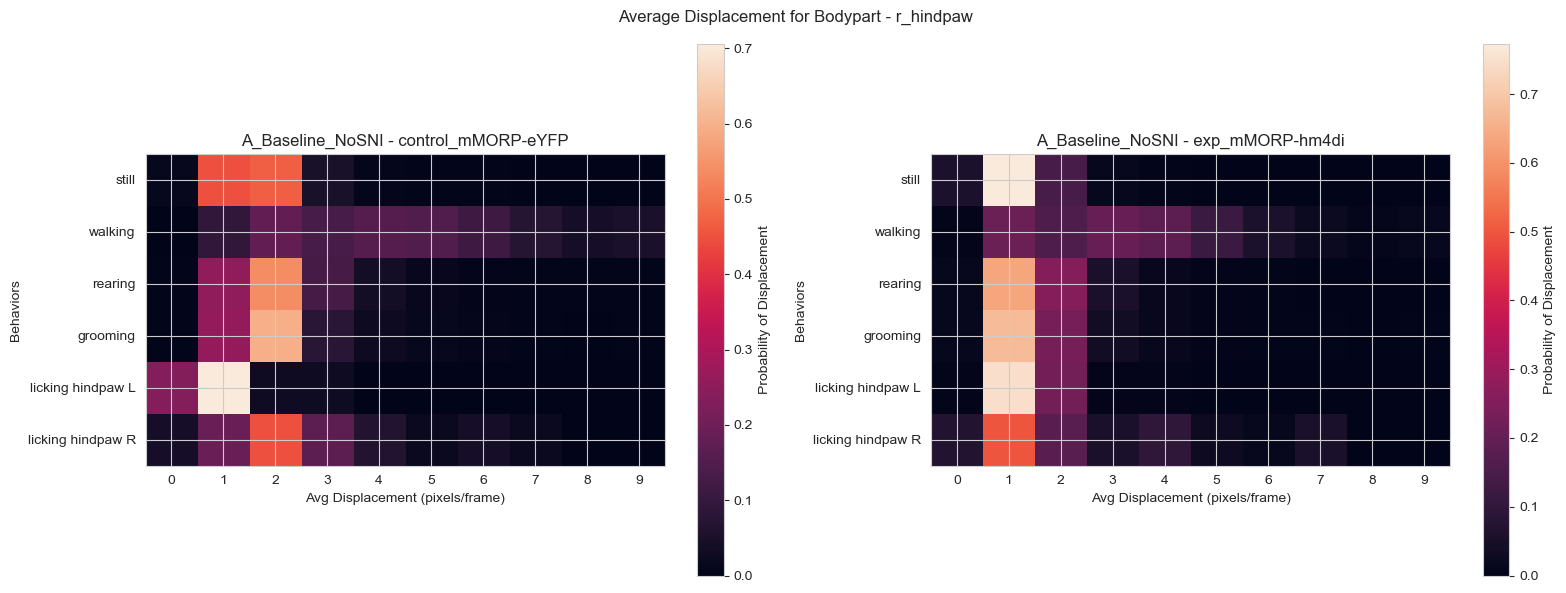

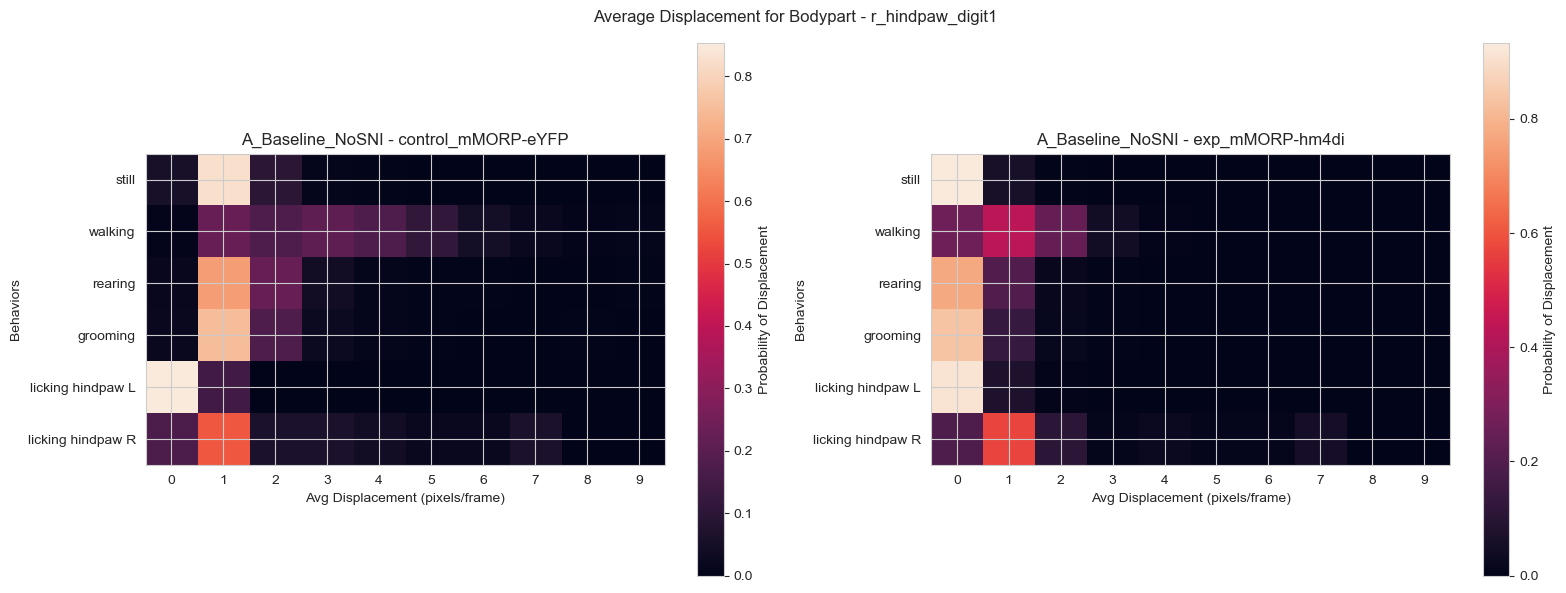

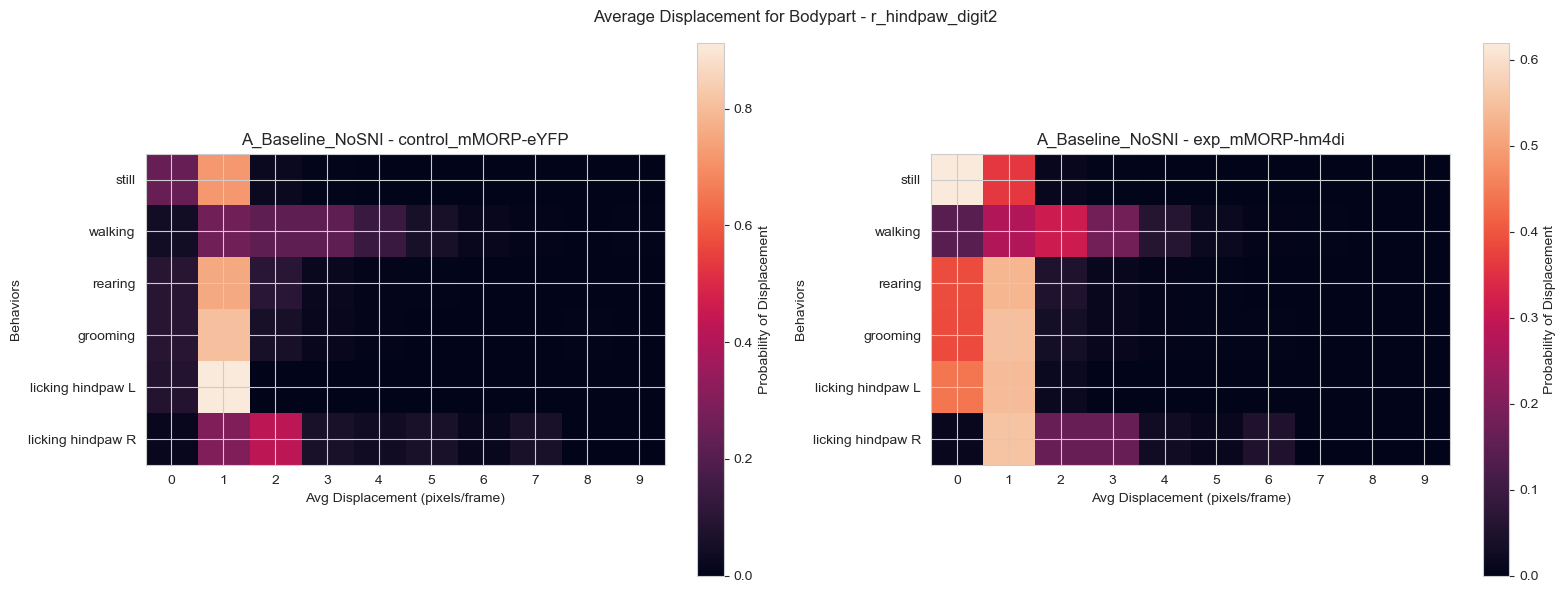

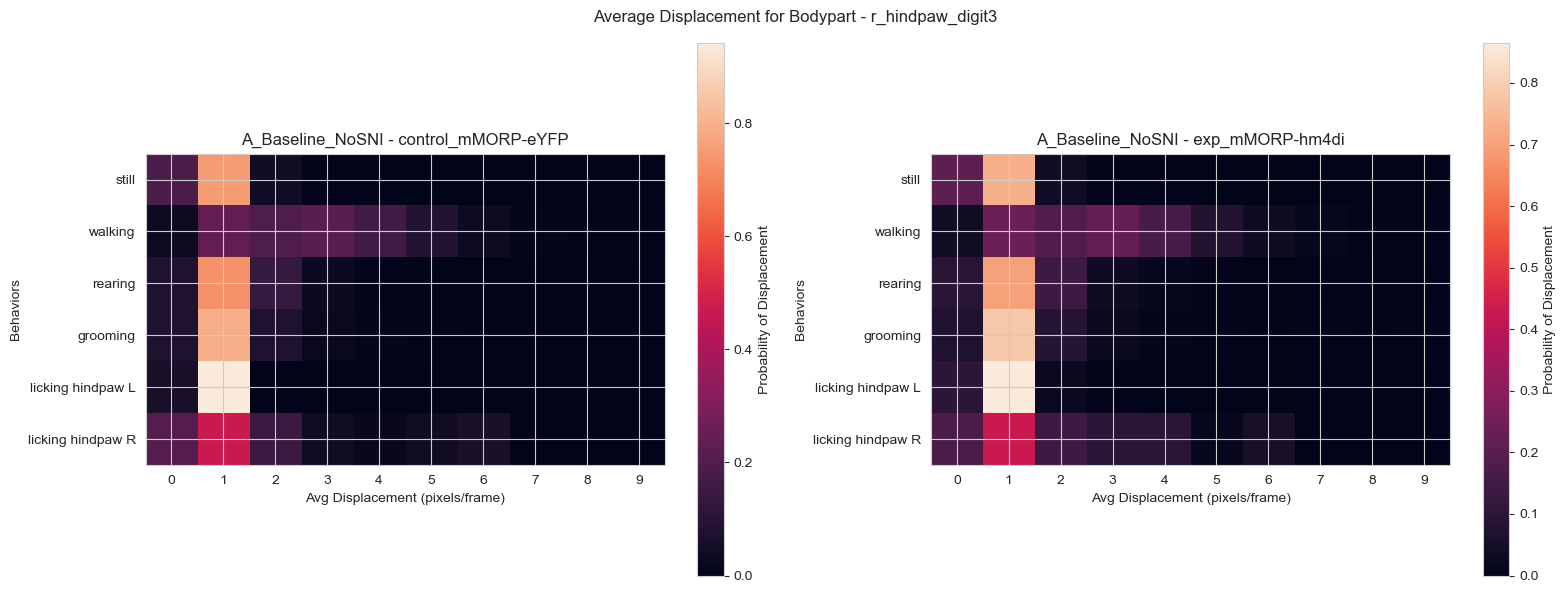

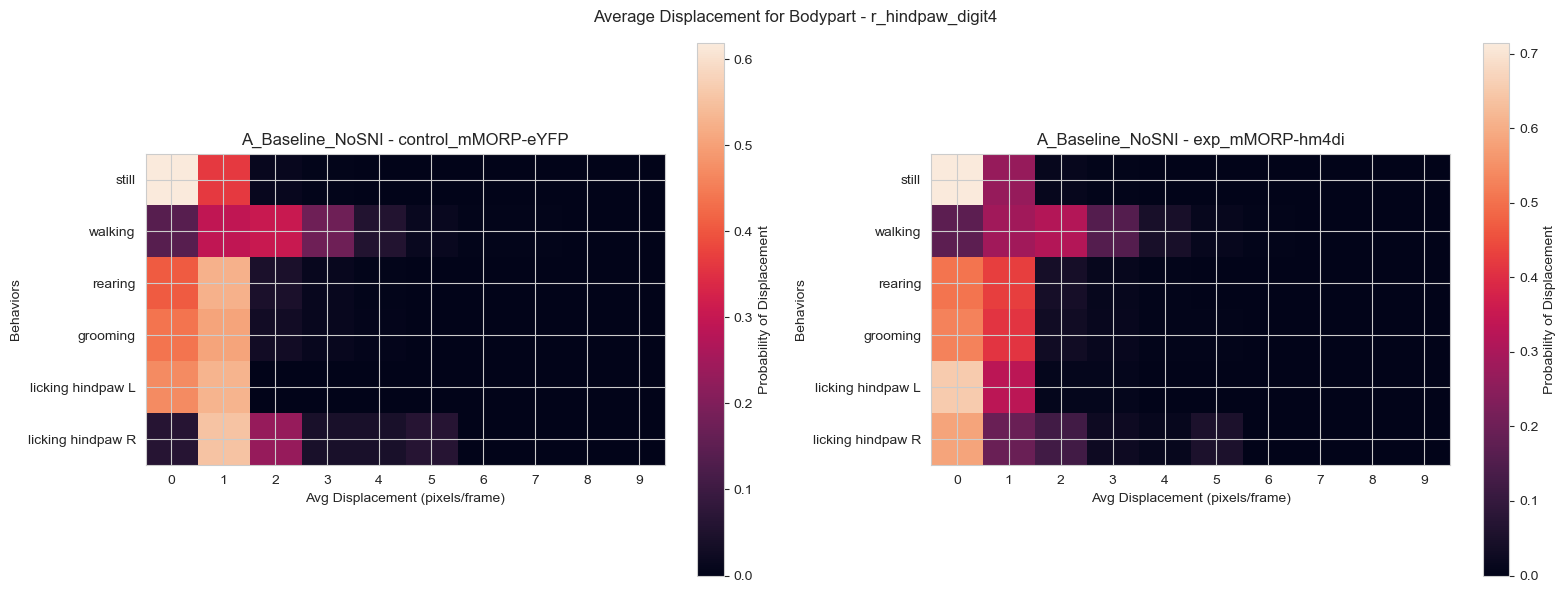

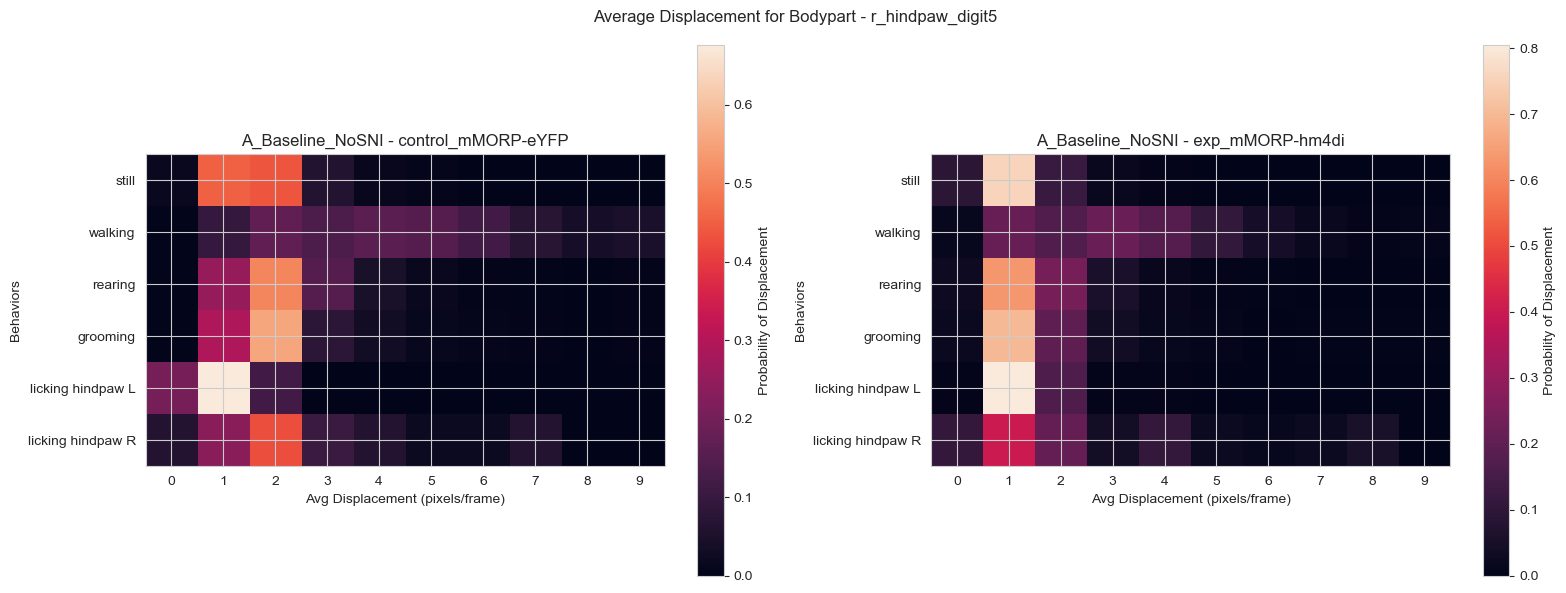

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from sklearn.preprocessing import LabelEncoder

# List of body parts to iterate over
#body_parts = ["l_hindpaw", "l_hindpaw_digit1", "l_hindpaw_digit2", "l_hindpaw_digit3", "l_hindpaw_digit4", "l_hindpaw_digit5"]
body_parts = ["r_hindpaw", "r_hindpaw_digit1", "r_hindpaw_digit2", "r_hindpaw_digit3", "r_hindpaw_digit4", "r_hindpaw_digit5"]

selected_group = 'A_Baseline_NoSNI'
# 'A_Baseline_NoSNI', 'B_Baseline_SNI', 'C_3WSNI_DCZ', 'D_4WSNI_DCZ'

selected_conditions = ['control_mMORP-eYFP', 'exp_mMORP-hm4di']  # Change to strings

# Initialize an empty dictionary to hold the results
movement_by_group_condition = {}

for bp_selects in body_parts:
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))  # 2 columns for 2 conditions

    for i, selected_condition in enumerate(selected_conditions):
        bout_disp_bps = []

        for bp_select in [bp_selects]:
            bodypart = keypoints.index(bp_select)
            bout_disp_all = []

            for j in range(len(behaviors[selected_group][selected_condition])):
                behavior, behavioral_start_time, behavior_duration, bout_disp, bout_duration, bout_avg_speed = \
                    get_avg_kinematics(behaviors[selected_group][selected_condition][f'file{j}'],
                                       poses[selected_group][selected_condition][f'file{j}'], 
                                       bodypart, framerate=60)
                bout_disp_all.append(bout_disp)

            bout_disp_bps.append(bout_disp_all)

        behavioral_sums = {key: [] for key in behavior_names}
        for b, behav in enumerate(behavior_names):
            behavioral_sums[behav] = np.hstack([np.hstack(
                [bout_disp_bps[bp][f][behav]
                 for f in range(len(bout_disp_bps[bp]))])
                for bp in range(len(bout_disp_bps))])

        max_perb = []
        for beh in list(behavioral_sums.keys()):
            if len(behavioral_sums[beh]) > 10:
                max_perb.append(np.percentile(behavioral_sums[beh], 95))
        max_all = np.max(max_perb)

        movement_n_bins = 10
        pre_alloc_movement = np.zeros((len(list(behavioral_sums.keys())), movement_n_bins))
        label_encoder = LabelEncoder()

        for b, behav in enumerate(list(behavioral_sums.keys())):
            df = pd.DataFrame(data=behavioral_sums[behav],
                              columns=['bp_movement'])
            n_bins = np.linspace(0, max_all, movement_n_bins)
            y = label_encoder.fit_transform(pd.cut(df['bp_movement'], n_bins, retbins=True)[0])
            pre_alloc_movement[b, :] = np.histogram(y, bins=np.arange(0, movement_n_bins+1))[0]

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            row_sums = pre_alloc_movement.sum(axis=1)
            movement_by_behav = pre_alloc_movement / row_sums[:, np.newaxis]

        movement_by_group_condition[(selected_group, selected_condition, bp_selects)] = movement_by_behav

        # Plotting
        heatmap = axs[i].imshow(movement_by_group_condition[(selected_group, selected_condition, bp_selects)])

        axs[i].set_title(f'{selected_group} - {selected_condition}')
        axs[i].set_xlabel('Avg Displacement (pixels/frame)')
        axs[i].set_ylabel('Behaviors')

        axs[i].set_xticks(np.arange(len(movement_by_behav[0])))
        axs[i].set_yticks(np.arange(len(behavior_names)))
        axs[i].set_yticklabels(behavior_names)

        fig.colorbar(heatmap, ax=axs[i], label='Probability of Displacement')

    plt.suptitle(f'Average Displacement for Bodypart - {bp_selects}')
    plt.tight_layout()

    plt.savefig(f'../figures/behavior_kinematx/avg_displacement_{selected_group}_r-hp.svg', format='svg')

    plt.show()


## MAIN CODE - CSV - COMBINED Male Female - Single Body Part, Single Condition

In [13]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

bp_selects = "genitalia"
selected_group = 'A_Baseline_NoSNI'
selected_condition = 'control_mMORP-eYFP'

# Initialize an empty dictionary to hold the results
average_displacement_by_behav = {}

bout_disp_bps = []

for bp_select in [bp_selects]:
    bodypart = keypoints.index(bp_select)
    bout_disp_all = []

    # Iterate over behaviors for the selected group and condition
    for i in range(len(behaviors[selected_group][selected_condition])):
        behavior, behavioral_start_time, behavior_duration, bout_disp, bout_duration, bout_avg_speed = \
            get_avg_kinematics(behaviors[selected_group][selected_condition][f'file{i}'],
                               poses[selected_group][selected_condition][f'file{i}'], 
                               bodypart, framerate=60)
        bout_disp_all.append(bout_disp)

    bout_disp_bps.append(bout_disp_all)

behavioral_sums = {key: [] for key in behavior_names}
for b, behav in enumerate(behavior_names):
    behavioral_sums[behav] = np.hstack([np.hstack(
        [bout_disp_bps[bp][f][behav]
         for f in range(len(bout_disp_bps[bp]))])
        for bp in range(len(bout_disp_bps))])

# Calculate the average displacement for each behavior
average_displacement_by_behav = {behav: np.mean(behavioral_sums[behav]) for behav in behavioral_sums}

# Convert dictionary to DataFrame
df = pd.DataFrame(average_displacement_by_behav, index=[0])

df.to_csv(f'../processed_dataset/behavior_kinematx/avg_displacement_{selected_group}-{selected_condition}_{bp_selects}.csv', index=False)

print("CSV file saved successfully.")

CSV file saved successfully.
